# **Insight dari Ulasan Aplikasi dengan AI: Studi Kasus IBM Granite dan Dataset Google Play**

Nama : Muhammad Daniel Ilyasa

## Install Library

In [ ]:
!pip install langchain_community
!pip install replicate
!pip install -U langchain langchain_community langchain_experimental replicate

##Import library

In [4]:
import pandas as pd
import os
from google.colab import userdata

api_token = userdata.get("api_token")

os.environ["REPLICATE_API_TOKEN"] = api_token

## Define Model IBM Granite

In [5]:
from langchain_community.llms import Replicate

# Define parameters
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 256,
"random_seed": None,
"repetition_penalty": 1.0,


}

model = "ibm-granite/granite-3.3-8b-instruct"

llm = Replicate(
    model=model,
    replicate_api_token=api_token,
    input = parameters
)

## Load Data

In [6]:
url = "https://raw.githubusercontent.com/daniel020901/Dataset/master/googleplaystore_user_reviews.csv"
df = pd.read_csv(url)
df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [8]:
df_valid = df.dropna(subset=['Translated_Review', 'App', 'Sentiment'])

In [9]:
from langchain_experimental.agents.agent_toolkits.pandas.base import (
    create_pandas_dataframe_agent)

agent = create_pandas_dataframe_agent(
    llm = llm,
    df=df,
    verbose=True,
    handle_parsing_errors=True,
    allow_dangerous_code=True
)

/usr/local/lib/python3.11/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


## Prompting Insight

In [10]:
agent.invoke({"input": "What is the meaning from this dataset?"})




> Entering new AgentExecutor chain...
Thought: The dataset appears to be a collection of customer reviews about a product, specifically "10 Best Foods for You". Each review has been analyzed for sentiment, and additional features such as Sentiment_Polarity and Sentiment_Subjectivity have been computed. There are missing values in the 'Translated_Review' and corresponding sentiment features for the third review.

Action: python_repl_ast

Action Input: 
```python
print("This dataset contains customer reviews for the product '10 Best Foods for You'. Each review is analyzed for sentiment and additional sentiment polarity and subjectivity features are computed. Notably, there are missing values for the third review's translated text and the associated sentiment features.")
```

This dataset contains customer reviews for the product '10 Best Foods for You'. Each review is analyzed for sentiment and additional sentiment polarity and subjectivity features are computed. Notably, there are mis

{'input': 'What is the meaning from this dataset?',
 'output': "This dataset contains customer reviews for the product '10 Best Foods for You'. Each review is analyzed for sentiment and additional sentiment polarity and subjectivity features are computed. Notably, there are missing values for the third review's translated text and the associated sentiment features."}

In [11]:

for idx, row in df_valid[['Translated_Review', 'App', 'Sentiment']].head(5).iterrows():
    review_text = row['Translated_Review']
    app_name = row['App']
    original_sentiment = row['Sentiment']

    prompt = f"""
You are an app review analyst. Your task is to read user reviews and determine the overall sentiment based on the tone and content of the review.

task:
1. Classify the sentiment as Positive, Neutral, or Negative.
2. Provide a short explanation justifying your classification.

Review Text: "{review_text}"
Original Label: {original_sentiment}
App Name: {app_name}
"""

    print(" Prompt:\n", prompt)
    ai_output = llm.invoke(prompt)
    print(" AI Output:\n", ai_output)
    print("-------------------------------\n")

 Prompt:
 
You are an app review analyst. Your task is to read user reviews and determine the overall sentiment based on the tone and content of the review.

task:
1. Classify the sentiment as Positive, Neutral, or Negative.
2. Provide a short explanation justifying your classification.

Review Text: "I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)""
Original Label: Positive
App Name: 10 Best Foods for You

 AI Output:
 1. Sentiment: Positive
2. Justification: Despite some grammatical errors, the review expresses a positive sentiment towards the "10 Best Foods for You" app. The user explicitly states that the app has been helpful in their cooking endeavors, particularly in finding delicious recipes and understanding food freshness through the "Best Before (Shelf Life)" feature. These statements indicate that the user finds value and utility in the app, leading to a positive sentiment classification.
-------------

In [12]:
def emotion_prompt(review_text):
    return f"""
context:
You are an expert in analyzing customer emotions in written reviews.

task:
Read the user review and identify the main emotion expressed in the text. Choose one word that best represents the user's emotion, such as: happy, annoyed, frustrated, excited, angry, satisfied, disappointed, confused, etc. Then provide a short explanation of your reasoning.

content:
"{review_text}"
"""

# Contoh implementasi untuk 5 review pertama
for idx, row in df_valid[['Translated_Review']].head(5).iterrows():
    prompt = emotion_prompt(row['Translated_Review'])
    output = llm.invoke(prompt)
    print(f"Review: {row['Translated_Review']}")
    print(" Emotion Detection Output:")
    print(output)
    print("---------------------------\n")


Review: I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
 Emotion Detection Output:
The main emotion expressed in the text is "satisfied." The user repeatedly emphasizes their positive experience with the "10 Best Foods" and "Best Before (Shelf Life)" resources, indicating satisfaction with the helpfulness and utility of these guides in their cooking endeavors. There is no indication of negative emotion or dissatisfaction in the provided content.
---------------------------

Review: This help eating healthy exercise regular basis
 Emotion Detection Output:
The main emotion expressed in the text is "satisfied". The user's statement, "This help eating healthy exercise regular basis", though grammatically incorrect and lacking context, implies a positive acknowledgment of assistance received for maintaining a healthy lifestyle through proper diet and exercise. The user seems content or satisfied with the support or 

In [13]:
def usefulness_prompt(review_text):
    return f"""
context:
You are a product analyst assisting mobile app developers. Your job is to read user reviews and determine whether they contain useful, actionable information for improving the app.

task:
1. Decide if the review is useful for developers (Yes/No)
2. Provide a short justification.

content:
"{review_text}"
"""

useful_outputs = []

for idx, row in df_valid[['Translated_Review']].head(5).iterrows():
    review_text = row['Translated_Review']
    prompt = usefulness_prompt(review_text)
    output = llm.invoke(prompt)
    print(f"Review: {review_text}")
    print(" Usefulness Output:")
    print(output)
    print("-----------------------------\n")
    useful_outputs.append(output)


Review: I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
 Usefulness Output:
1. Yes
2. The review, despite being off-topic and incoherent, contains a mention of the "10 Best Foods" feature. This suggests that the feature is valued by users for its usefulness in cooking or meal planning. Developers could leverage this feedback to reinforce and potentially expand the "10 Best Foods" feature, ensuring it remains a valuable tool for users interested in cooking or nutrition. Additionally, the reference to "Best Before (Shelf Life)" indicates that users appreciate content related to food freshness and storage, which could inspire developers to include or improve related features.
-----------------------------

Review: This help eating healthy exercise regular basis
 Usefulness Output:
1. Yes
2. This review, while brief, suggests that users find value in the app's features related to maintaining a healthy diet and exerc

In [14]:
agent.invoke({"input": "How many positive, neutral, and negative reviews are in the dataset?"})




> Entering new AgentExecutor chain...
Thought: To determine the count of positive, neutral, and negative reviews, I need to first identify the values in the 'Sentiment' column that correspond to each category. From the given data, positive reviews are denoted as 'Positive', neutral reviews are marked as 'Neutral', and negative reviews as 'Negative'. I will count the occurrences of each sentiment in the 'Sentiment' column.

Action: python_repl_ast
Action Input: 
```python
positive_count = (df['Sentiment'] == 'Positive').sum()
neutral_count = (df['Sentiment'] == 'Neutral').sum()
negative_count = (df['Sentiment'] == 'Negative').sum()

(positive_count, neutral_count, negative_count)
```
(np.int64(23998), np.int64(5163), np.int64(8271))Based on the provided data, there are 23,998 positive reviews, 5,163 neutral reviews, and 8,271 negative reviews.

Final Answer:
- Positive reviews: 23,998
- Neutral reviews: 5,163
- Negative reviews: 8,271

> Finished chain.


{'input': 'How many positive, neutral, and negative reviews are in the dataset?',
 'output': '- Positive reviews: 23,998\n- Neutral reviews: 5,163\n- Negative reviews: 8,271'}



> Entering new AgentExecutor chain...
Thought: To plot a bar chart showing the count of each sentiment class, I need to count the occurrences of each sentiment in the 'Sentiment' column of the dataframe. I will use the `value_counts()` function to achieve this. Then, I will use the `matplotlib` or `seaborn` library to create the bar chart.

Action: python_repl_ast

Action Input:
```python
sentiment_counts = df['Sentiment'].value_counts()
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='bar')
plt.title('Count of Each Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
```



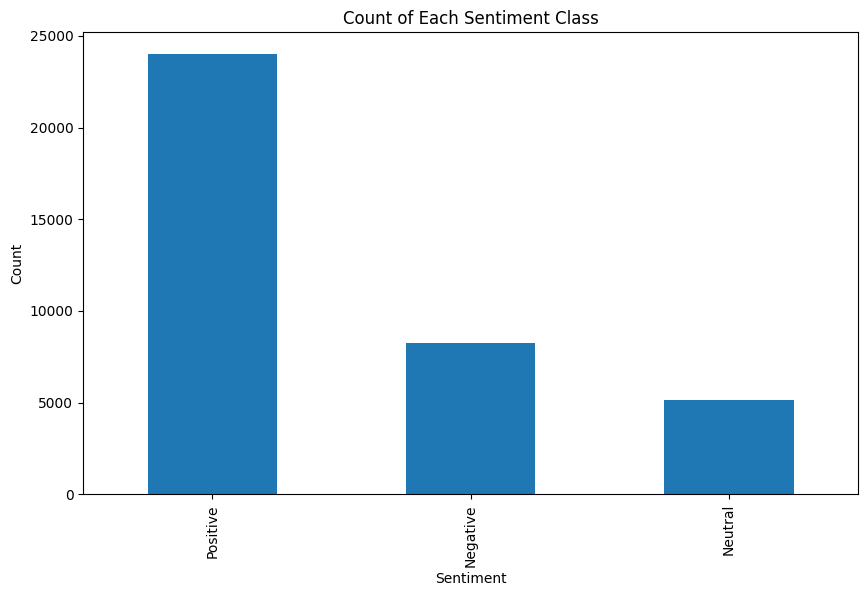

The observation here is not directly visible as this is a code execution to generate a plot. After executing the code, a bar chart will be displayed showing the count of each sentiment class in the 'Sentiment' column. 

The code performs the following steps:
1. Counts the occurrences of each sentiment in the 'Sentiment' column using `value_counts()` and stores it in `sentiment_counts`.
2. Imports the `matplotlib.pyplot` module as `plt`.
3. Creates a figure with specified size using `plt.figure(figsize=(10,6))`.
4. Plots the bar chart using `sentiment_counts.plot(kind='bar')`.
5. Sets the title and labels for x and y axes.
6. Displays the plot with `plt.show()`.

Final Answer:
A bar chart will be displayed showing the count of each sentiment class in the 'Sentiment' column of the dataframe. Without directly showing the plot here, I describe its content: It will have sentiment categories on the x-axis (Positive, Negative, and Neutral, assuming those are present in the data) and their res

{'input': 'Plot a bar chart showing the count of each sentiment class.',
 'output': "A bar chart will be displayed showing the count of each sentiment class in the 'Sentiment' column of the dataframe. Without directly showing the plot here, I describe its content: It will have sentiment categories on the x-axis (Positive, Negative, and Neutral, assuming those are present in the data) and their respective counts on the y-axis. Each sentiment will have a bar whose"}

In [15]:
agent.invoke({"input": "Plot a bar chart showing the count of each sentiment class."})
